# What can job descriptions tell us about our workforce?

The workforce in Australia is highly gender segregated, with the majority of Australians working in an [industry dominated by one gender or another](https://www.wgea.gov.au/data/fact-sheets/gender-segregation-in-australias-workforce). Why do we care? Because study after study has shown that organizations are more creative, productive, and successful with a diverse range of staff.

A small number of [well documented practices](https://business.linkedin.com/talent-solutions/blog/job-descriptions/2018/5-must-dos-for-writing-inclusive-job-descriptions) are recommended to design job descriptions that will attract candidates from multiple genders. Use of these [strategies](
https://blog.criteriacorp.com/6-simple-steps-to-reduce-gender-bias-in-your-job-descriptions) results in not just more female applicants, but a larger overall applicant field.

There are existing tools to assist organizations looking to improve in these areas. For example, the [gender decoder](http://gender-decoder.katmatfield.com/) is a free online tool that checks for use of gender-coded words. For larger-scale implementation, it's available as both an Anaconda package and a github repo, so there are few excuses not to try it out.

Don't think it matters? Have a look at the success of [predicting genders of hires based solely on analysis of job descriptions](https://textio.ai/gendered-language-in-your-job-post-predicts-the-gender-of-the-person-youll-hire-cd150452407d) at Expedia. How you advertise a role is a strong predictor of who you will hire - in many cases companies and recruiters are including more communication to potential applicants than they realize.

             
__Goals: I seek to understand the level of implementation of good practices in job descriptions for attracting diverse candidates by:__
1. Identifying features within job descriptions which are correlated with that job coming from an industry dominated by a particular gender
2. Developing a model which predicts whether a job description is presenting a role in a female-dominated, male-dominated, or mixed industry
3. Estimating the percentage of position descriptions including and Equal Opportunity Employer statement in differing industries

__Metrics: I am measuring success in the following ways:__
* Accuracy in predicting the gender-dominance of job descriptions not used in training the model, but from industries used in training
* Accuracy in predicting the gender-dominance of job descriptions from industries not used in training
* Identification of features that differentiate gender-dominance predictions from industry-specific predictions
* Estimating effectiveness in identifying inclusion of Equal Opportunity Employer Statements

__Findings/Results:__
* The gender dominance of the industry a job description comes from can be predicted with 75-85% accuracy.
* The words used in the job description are the most highly predictive feature, with relative comparison of how frequently words appear in a given job description to how frequently they appear in jds the model was trained on being the strongest feature.
* Text sentiment and total size of vocabulary in the job description also have some predictive value
* Although not a direct feature of job description, the distribution of company ratings also varies across industries dominated by different genders

__Assumptions, Risks, and Limitations__ <br>
With this dataset, it is difficult to separate differences in industry and job type from differences in language used in job descriptions. One could validly argue that the type of work being done in different industries makes it sensible that different styles of language will be used to present these roles. Conversely, it is the perception of these roles in society which solidify and continue industry gender segregation, and the way those roles are presented in job descriptions is one key element in the cycle. Potentially including data from a single large multi-industry employer such as a hospital or regional health system with analysts, nurses, and hospitality staff managed by a single HR system could inform this gap in the future. A/B testing using job descriptions intentionally designed to match the style of those from opposite-gender-dominated industries could provide interesting opportunities for further study.

__Future Directions and Improvements__
* Incorporate estimation of number of qualifications/requirements included, as this is one of the biggest issues for attracting diverse applications
* BERT / Neural networks - neural networks work well for NLP tasks due to the ability to incorporate context, which is an essential element of language. One direction for this would be using  pre-trained base layers from general language, then training a final layer on job descriptions.
* Incorporate training data from a wider range of industries
* Allow multi-industry tagging (e.g. an analysts in retail, finance, or mining may have different characteristics)
* Incorporate modelling of position level (e.g. manager / executive)


In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics

import pickle
import dill

import scipy.stats as stats
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [3]:
from textblob import TextBlob, Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import scattertext as st
import spacy
import string

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
C:\ProgramData\Anaconda3\lib\site-packages\thinc\neural\train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
C:\ProgramData\Anaconda3\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence,

## Exploratory Data Analysis
1. LDA
2. Relationships with company rating
3. Relationships with sentiment (vader and TextBlob)
4. Word cloud
 

In [14]:
#importing data
jobs_original = pd.read_csv('./data/alljobs_clean.csv')
print(jobs_original.shape)
jobs_original.head()

(20028, 12)


,company,company_rating,industry,job_description_all_text,job_title,location,salary_data_text,jd_no_stopwords,salary_values,salary_period,salary_multiplier,annual_salary
0,ANZ Banking Group,4.1,data,"Consultant Data Scientist – Data Activation, M...",Data Scientist Consultant,Melbourne,NaN,"['consultant', 'data', 'scientist', '–', 'data...",NaN,NaN,NaN,NaN
1,NAB - National Australia Bank,3.8,data,Work type: Permanent Full time\nLocation: Aust...,Data Scientist,Melbourne,NaN,"['work', 'type', 'permanent', 'full', 'time', ...",NaN,NaN,NaN,NaN
2,ANZ Banking Group,4.1,data,The Team\n\nThe Customer Service Operations Au...,Senior Data Scientist,Melbourne,NaN,"['team', 'customer', 'service', 'operations', ...",NaN,NaN,NaN,NaN
3,NAB - National Australia Bank,3.8,data,Work type: Permanent Full time\nLocation: Aust...,Data Analytics Engineer,Melbourne,NaN,"['work', 'type', 'permanent', 'full', 'time', ...",NaN,NaN,NaN,NaN
4,Coles,3.8,data,About Us\n\nThe Digital team is focused on rei...,Data Scientist,Melbourne,NaN,"['us', 'digital', 'team', 'focused', 'reinvent...",NaN,NaN,NaN,NaN


In [15]:
jd_df = jobs_original.copy()
print ('Total rows:',jd_df.shape[0], '\n')
print ('Rows missing data:')
jd_df.isna().sum()

Total rows: 20028 

Rows missing data:


company                        52
company_rating               9233
industry                        0
job_description_all_text        0
job_title                       0
location                        0
salary_data_text            15280
jd_no_stopwords                 0
salary_values               15280
salary_period               15280
salary_multiplier           15280
annual_salary               15280
dtype: int64

In [16]:
#still has newline characters in jd - removing from title as well, just in case
jd_df.job_description_all_text = [jd.replace('\n', ' ') for jd in jd_df.job_description_all_text]
jd_df.job_title = [title.replace('\n', ' ') for title in jd_df.job_title]

In [17]:
jd_df['gender_dominance'] = ['male' if ((industry == 'data') | (industry == 'manufacturing') | (industry == 'construction')) 
        else 'female' if ((industry == 'nursing') | (industry == 'early_learning'))
       else 'mixed' for industry in jd_df.industry]

jd_df.gender_dominance.value_counts()

mixed     8217
male      8002
female    3809
Name: gender_dominance, dtype: int64

__Above numbers raise a class imbalance concern__
Currently mixed and male classes are evenly represented, but female is much fewer; may need to collect additional data or use resampling techniques to improve balance

In [8]:
### LDA (Latent Dirichlet Allocation)

In [9]:
cvect = CountVectorizer(strip_accents='unicode', 
                          stop_words='english',
                          lowercase='true',
                          token_pattern=r'\b[a-zA-Z]{3,}\b',
                          max_df=0.5,
                          min_df=10)

dtm_tf = cvect.fit_transform(jd_df.job_description_all_text)
print(dtm_tf.shape)


(20025, 11431)


In [10]:
#matching number of components to number of industries
lda_tf = LatentDirichletAllocation(n_components=8, random_state=0)
lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [11]:
#visualizing and saving results
# pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vect)
lda_vis_tf = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, cvect)
pyLDAvis.save_html(lda_vis_tf, './images/lda_tf.html')
lda_vis_tf

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.053978 -0.094827       1        1  15.710137
3     -0.127459  0.109167       2        1  13.997860
1      0.080489 -0.028593       3        1  13.964846
4      0.151753 -0.050354       4        1  12.721578
2      0.048768 -0.020971       5        1  11.515625
0     -0.174614 -0.128328       6        1  11.314713
6      0.108492  0.031766       7        1  11.047756
5     -0.033451  0.182140       8        1   9.727484, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
2696   Default  17153.000000          data  17153.000000  30.0000  30.0000
1563   Default  15059.000000          care  15059.000000  29.0000  29.0000
4820   Default  13067.000000        health  13067.000000  28.0000  28.0000
1804   Default   7595.000000      children   7595.000000  27.0000  27.0000
1427   Default  27671.000000      business  27671.000000  26.0000  26.0000
8962   Default  10890.000000         sales  10890.000000  25.0000  25.0000
4113   Default   8352.000000     financial   8352.000000  24.0000  24.0000
2649   Default  17346.000000      customer  17346.000000  23.0000  23.0000
8719   Default   7541.000000        retail   7541.000000  22.0000  22.0000
9824   Default   5188.000000         store   5188.000000  21.0000  21.0000
4111   Default   6494.000000       finance   6494.000000  20.0000  20.0000
1915   Default   4701.000000      clinical   4701.000000  19.0000  19.0000
7985   Default   8346.000000       project   8346.000000  18.0000  18.0000
9049   Default   3564.000000        school   3564.000000  17.0000  17.0000
9901   Default   2796.000000      students   2796.000000  16.0000  16.0000
7793   Default   6428.000000     preferred   6428.000000  15.0000  15.0000
6944   Default   3437.000000       nursing   3437.000000  14.0000  14.0000
3363   Default   6852.000000     education   6852.000000  13.0000  13.0000
7417   Default  15580.000000        people  15580.000000  12.0000  12.0000
2650   Default   9392.000000     customers   9392.000000  11.0000  11.0000
3303   Default   5166.000000         early   5166.000000  10.0000  10.0000
6941   Default   3176.000000         nurse   3176.000000   9.0000   9.0000
5883   Default   8540.000000      learning   8540.000000   8.0000   8.0000
481    Default   3195.000000     analytics   3195.000000   7.0000   7.0000
302    Default   2981.000000          aged   2981.000000   6.0000   6.0000
10228  Default   7153.000000     technical   7153.000000   5.0000   5.0000
8589   Default   7231.000000     reporting   7231.000000   4.0000   4.0000
475    Default   5989.000000      analysis   5989.000000   3.0000   3.0000
8628   Default   4567.000000      research   4567.000000   2.0000   2.0000
88     Default   2710.000000    accounting   2710.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
847     Topic8    937.220608        august   1425.139265   1.9111  -6.0038
31      Topic8    592.769116      academic    856.941392   1.9617  -6.4619
3482    Topic8   2230.898282    employment   4950.196162   1.5332  -5.1366
4820    Topic8   4593.864484        health  13067.232915   1.2848  -4.4142
2085    Topic8   2396.714551     community   6259.122113   1.3703  -5.0649
738     Topic8    982.648973    assessment   1866.292846   1.6888  -5.9565
2574    Topic8   1379.049299      criteria   3073.902689   1.5287  -5.6176
7691    Topic8   3457.218476      position  12214.682697   1.0680  -4.6985
2838    Topic8   1842.296130  demonstrated   4993.733674   1.3330  -5.3280
7976    Topic8   1655.644206      programs   4350.442197   1.3641  -5.4348
5883    Topic8   2543.165826      learning   8540.886629   1.1188  -5.0056
3363    Topic8   2164.916779     education   6852.708756   1.1780  -5.1666
6927    Topic8   1107.024881           nsw

<Figure size 1440x1296 with 0 Axes>

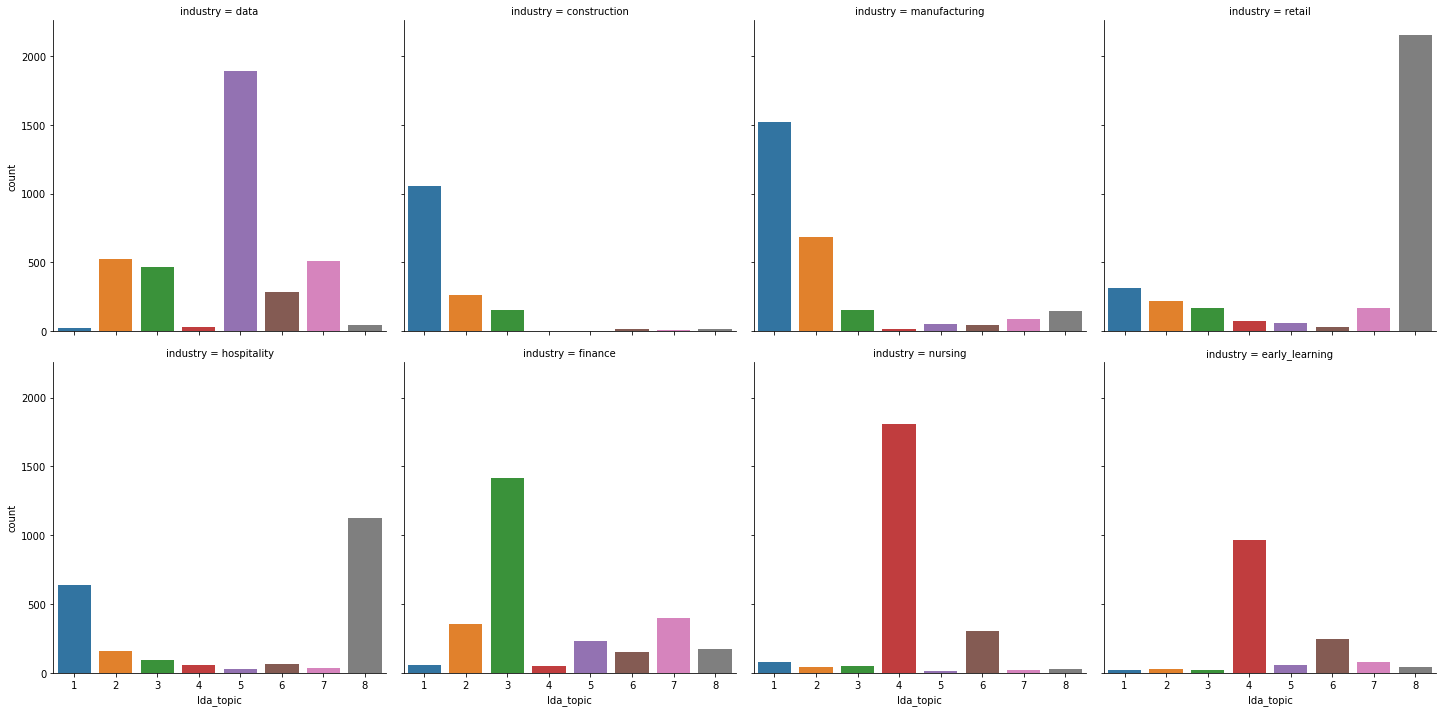

In [18]:
#quick check: how well do topics represent industries?
lda_topics = lda_tf.transform(dtm_tf)
jd_df['lda_topic'] = [(topic.argmax() + 1) for topic in lda_topics]
plt.figure(figsize=(20,18))
LDA_by_industry = sns.catplot(col='industry', x='lda_topic', data=jd_df, kind='count', col_wrap=4)
LDA_by_industry.savefig("./images/LDA_by_industry.png")


### Company rating

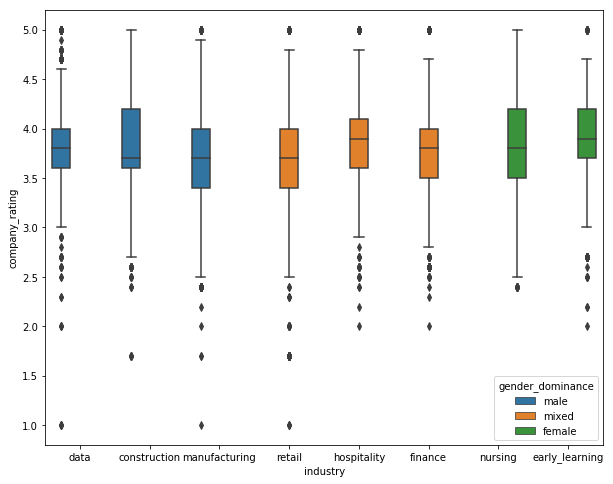

In [18]:
plt.figure(figsize=(10,8))
sns.boxplot(x='industry', y='company_rating', hue = 'gender_dominance', data=jd_df)

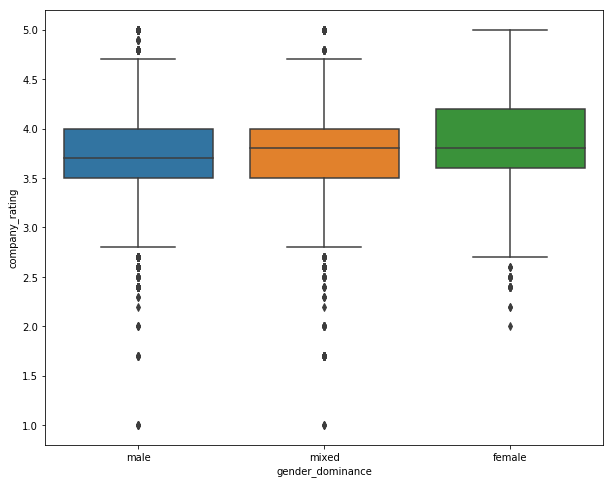

In [19]:
plt.figure(figsize=(10,8))
sns.boxplot(x='gender_dominance', y='company_rating', data=jd_df)

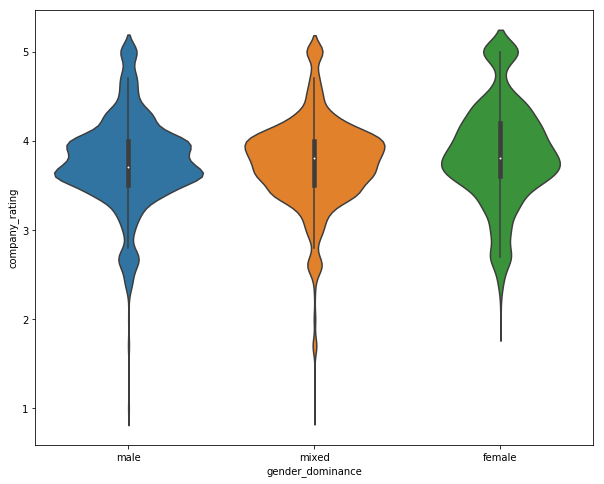

In [10]:
plt.figure(figsize=(10,8))
sns.violinplot(x='gender_dominance', y='company_rating', data=jd_df)

In [11]:
print('Mean',  '\n', jd_df.groupby('gender_dominance')['company_rating'].mean())
print('Median',  '\n', jd_df.groupby('gender_dominance')['company_rating'].median())


Mean 
 gender_dominance
female    3.853239
male      3.761165
mixed     3.759106
Name: company_rating, dtype: float64
Median 
 gender_dominance
female    3.8
male      3.7
mixed     3.8
Name: company_rating, dtype: float64


In [8]:
#is this difference significant?  
#H0: means are statistically equivalent between company ratings for male and female 
#H1: means are different with alpha < 0.05
ratings = jd_df.dropna(subset=['company_rating'])
stats.ttest_ind(ratings[ratings.gender_dominance == 'male']['company_rating'], 
                ratings[ratings.gender_dominance == 'female']['company_rating'])

Ttest_indResult(statistic=-6.576744878728554, pvalue=5.1938473985675644e-11)

#### Company rating may be a potential predictor
The difference in means is significant, so we can consider including company rating in modelling.

### Sentiment exploration
Calculating via both vaderSentiment and TextBlob sentiment polarity

In [5]:
#currently the jd_no_stopwords column is a list of words represented as a string ("['word', 'word', ...]")
#using this to covert to just a string of words separated by spaces
#a few extraneous characters will also remain
def jd_no_stops_stripper(text):
    new_text = text.replace(',',' ').strip('[]').replace("'",'')
    return(new_text)


In [ ]:
jd_df.jd_no_stopwords = jd_df.jd_no_stopwords.map(jd_no_stops_stripper)

In [23]:
#checking that this got the expected result
jd_df.jd_no_stopwords[8347]

'sc  carpentry  constructions  looking  hire  accounts  administration  assistant  small  yet  busy  office  start  asapyour  daytoday  responsibilities  managing  reception  accounts  payable  receivable  bank  general  ledger  account  reconciliation  general  adhoc  duties  managing  social  media  platformsskills  experience  must  proficient  microsoft  office  myob  experience  must  background  bookkeeping  administrationjob  type  parttimesalary  2000  3000  hourexperienceadministrative  assistant  1  year  preferred'

In [13]:
#generating sentiment for jd text
#generating two values using vaderSentiment and TextBlob

vader = SentimentIntensityAnalyzer()
jd_df['vader_sentiment'] = [vader.polarity_scores(jd) for jd in jd_df.jd_no_stopwords]

In [14]:
vader_sentiment_neg = jd_df.vader_sentiment.map(lambda x: x['neg'])
vader_sentiment_pos = jd_df.vader_sentiment.map(lambda x: x['pos'])
vader_sentiment_neu = jd_df.vader_sentiment.map(lambda x: x['neu'])
vader_sentiment_compound = jd_df.vader_sentiment.map(lambda x: x['compound'])

In [15]:
jd_df['vader_sentiment_neg'] = vader_sentiment_neg
jd_df['vader_sentiment_pos'] = vader_sentiment_pos
jd_df['vader_sentiment_neu'] = vader_sentiment_neu
jd_df['vader_sentiment_compound'] = vader_sentiment_compound

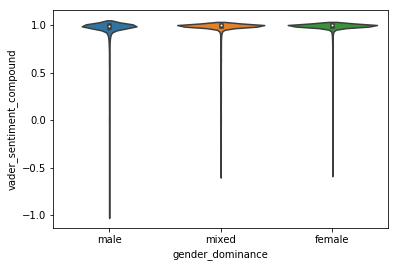

In [20]:
sns.violinplot(x='gender_dominance', y='vader_sentiment_compound', data=jd_df)

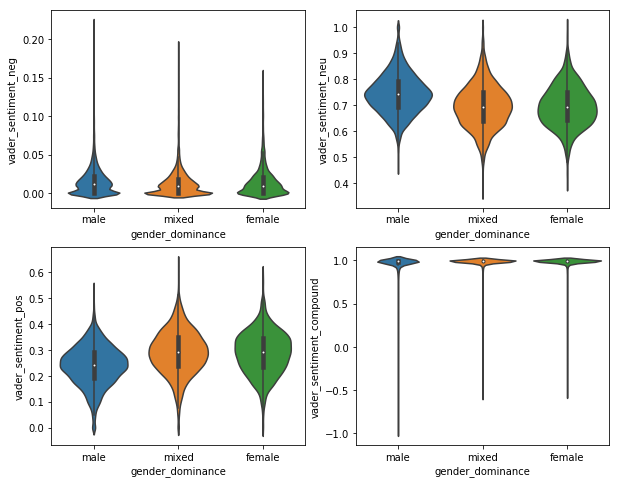

In [16]:
###need to put these and below next to each other
#visualize by industry
fig, axes = plt.subplots(2,2,figsize=(10,8))

for i, sentiment in enumerate(['neg','neu','pos','compound']):

    y_string = 'vader_sentiment_' + sentiment

    axi = plt.subplot(2,2,(i+1))     
    sns.violinplot(x='gender_dominance', y=y_string, data=jd_df, ax=axi)
    
fig.savefig('./images/sentiments_violinplots.png')

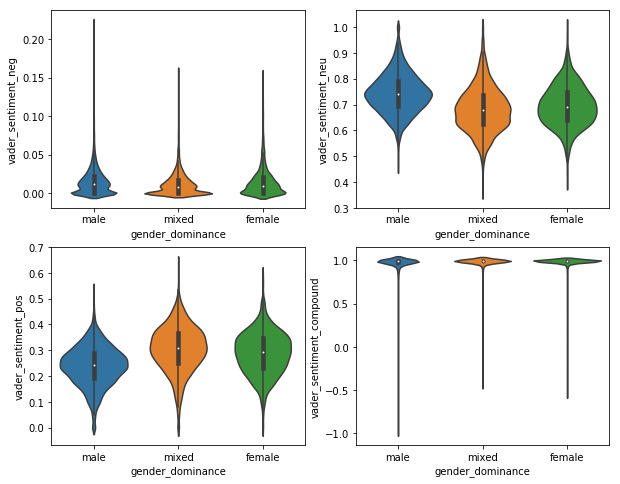

In [22]:
#any different without finance in mixed?
fig, axes = plt.subplots(2,2,figsize=(10,8))

no_finance = jd_df[jd_df.industry != 'finance']

for i, sentiment in enumerate(['neg','neu','pos','compound']):
    y_string = 'vader_sentiment_' + sentiment
    
    axi = plt.subplot(2,2,(i+1))
    sns.violinplot(x='gender_dominance', y=y_string, data=no_finance, ax=axi)

In [23]:
#what does one of the more separated distribuations look like numerically?
jd_df.groupby('gender_dominance')['vader_sentiment_neu'].agg(['mean','median']).sort_values('mean')

,mean,median
gender_dominance,,
female,0.695654,0.692
mixed,0.696162,0.694
male,0.744021,0.741


In [16]:
def detect_sentiment(text):
    return(TextBlob(text).sentiment.polarity)

In [17]:
jd_df['textblob_sentiment'] = jd_df.jd_no_stopwords.map(detect_sentiment)

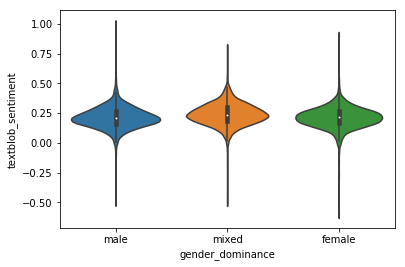

In [26]:
#visualize by gender dominance
sns.violinplot(x='gender_dominance', y='textblob_sentiment', data=jd_df)

Are the differences in means significant? Let's run a t-test to investigate

H0: The difference in sentiment (starting with calculations of sentiment with largest visual difference) between industries dominated by different genders is 0. <br>
H1: The difference in sentiment between industries dominated by different genders is not 0.

In [18]:
#creating separate dataframe for sentiment exploration
sentiment_cols = [col for col in jd_df.columns if 'sentiment' in col]
sentiment_cols.remove('vader_sentiment')

t_tests = {}
for col in sentiment_cols:
    t_test = stats.ttest_ind(jd_df[jd_df.gender_dominance == 'male'][col], 
                             jd_df[jd_df.gender_dominance == 'female'][col])
    t_tests[col] = t_test
    
t_test_df = pd.DataFrame(t_tests).transpose()
t_test_df.columns = ['test_statistic', 'p_val']
t_test_df.head()

,test_statistic,p_val
vader_sentiment_neg,2.569006,1.021125e-02
vader_sentiment_pos,-32.098546,8.125746e-217
vader_sentiment_neu,31.725632,4.704396e-212
vader_sentiment_compound,-10.961194,7.994673e-28
textblob_sentiment,-0.354023,7.233278e-01


#### Most sentiment columns could be useful features
Vader positive, neutral, and compound sentiments are all significant to a very low threshold <br>
Vader negative is significant to .01 threshold, so surpasses the .05 stated for our test <br>
Textblob sentiment does not meet the .05 threshold - this sentiment indicator is essentially the same across industry types <br>


In [21]:
def get_top_n_words(corpus, n=None):
    """
    Create dictionary of the top n words in a vocabulary according to occurrence in a text corpus.

    """
    cvec = CountVectorizer().fit(corpus)
    bag_of_words = cvec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Most common words
Some of these may need to be added to stopwords as they will be uninformative <br>
Will need to investigate, though, as some may still be informative

In [22]:
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

def create_word_cloud(string, image_template, file_path):
   maskArray = np.array(Image.open(image_template))
   cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file(file_path)


In [32]:
import multidict as multidict

import os
from os import path


def get_frequency_dict_for_text(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def make_image(text,image_template):
    mask = np.array(Image.open(image_template))

    wc = WordCloud(background_color="white", max_words=1000, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    
def makeImage(text, image_template):    
    wordcloud = WordCloud(width=900,height=500, max_words=50,
                          relative_scaling=1,
                          normalize_plurals=True,
                          mask = np.array(Image.open(image_template))
                         ).generate_from_frequencies(text)
    


In [24]:
top_100_words = get_top_n_words(jd_df.jd_no_stopwords)
top_100_words[0:5]

[('experience', 45960),
 ('work', 43036),
 ('team', 41242),
 ('role', 32934),
 ('skills', 27829)]

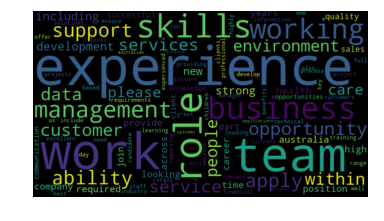

In [25]:
top_100_dict = dict((x,y) for x, y in top_100_words)
wordcloud = WordCloud(width=900,height=500, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(top_100_dict)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('./images/top100_wordcloud.png')

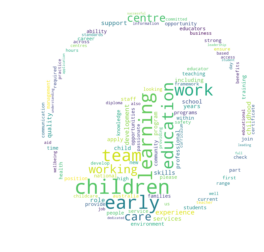

In [31]:
make_image(top_100_dict, './images/wolf_template.png')

In [27]:
top100words_by_industry = {}
for industry in jd_df.industry.unique():
    
    corpus = jd_df.jd_no_stopwords[jd_df.industry == industry]
    top_100_words = get_top_n_words(corpus, n=100)

    top_100_dict = dict((x,y) for x, y in top_100_words)
    
    top100words_by_industry[industry] = top_100_dict


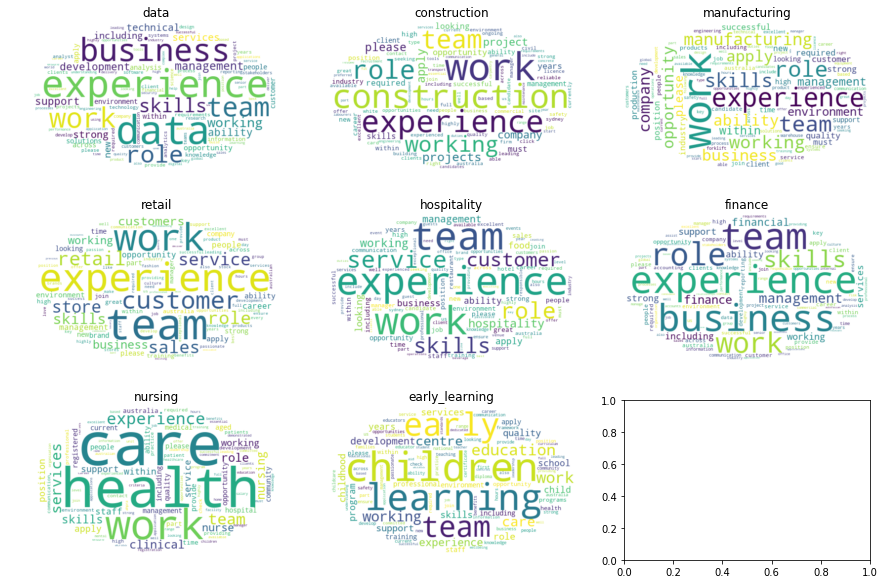

In [29]:
##CREATE WORD CLOUDS FOR EACH INDUSTRY
fig, axes = plt.subplots(3,3, figsize=(15,10))
for i, industry in enumerate(jd_df.industry.unique()):
    ax = plt.subplot(3,3,i+1)
    ax.set_title(industry)
    make_image(top100words_by_industry[industry], './images/oval.jpg')

fig.savefig('./images/industry_wordclouds.png')

#### Scatterplot comparing words used in female vs male industries
This takes ages to run, so commenting out code <br>
Saved html file is also slow to load 

In [79]:
# male_df = jd_df[jd_df.gender_dominance=='male']
# female_df = jd_df[jd_df.gender_dominance=='female']

# male_female_df = pd.concat([test_male_df, test_female_df])
# print(female_df.shape, male_female_df.shape)


(3809, 23) (11811, 23)


In [80]:
# #adapting from scatterplot overview
# #https://github.com/JasonKessler/scattertext#overview

# nlp = spacy.load('en')

# corpus = st.CorpusFromPandas(male_female_df, 
#                             category_col='gender_dominance',
#                             text_col='job_description_all_text',
#                             nlp=spacy.load('en')).build()

# html = st.produce_scattertext_explorer(corpus,
#                                        category='female',
#                                        category_name='Female',
#                                        not_category_name='Male',
#                                        metadata=male_female_df.job_title,
#                                        width_in_pixels=1000)

# open("./images/female_jd_text.html", 'wb').write(html.encode('utf-8'))

C:\ProgramData\Anaconda3\lib\site-packages\scattertext\TermDocMatrix.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  corpus_unigram_freq = corpus_freq_df.ix[[term for term


39118488

### Gender Coded Words

For this portion of the analysis, we are using the word list from the [Gender Decoder](http://gender-decoder.katmatfield.com/), a free online tool to analyze gender coding in job descriptions. You can learn more about the research behind this word list [here](http://gender-decoder.katmatfield.com/static/documents/Gaucher-Friesen-Kay-JPSP-Gendered-Wording-in-Job-ads.pdf).

Some noteable points:
1. The research is from 2011. It is still frequently cited in HR industry blogs and articles, but I am curious if any updated research on word associations exists.
2. The research was conducted in Canada. I think that gender cultures in Australia and Canada share many features, but there is also a potential mis-representation when using out-of-context social research.



In [24]:
def load_coded_words(masculine_file='./data/masculine_coded_words.txt', 
                     feminine_file='./data/feminine_coded_words.txt'):
    masculine_coded_words = pd.read_csv(masculine_file, names=['masculine'])
    feminine_coded_words = pd.read_csv(feminine_file, names = ['feminine'])


In [6]:
#for words in masculine & feminine lists (used as stems), check if in jd, if so, store word and count from dictionary
#very unsure this is pulling out all relevant matches


def match_word_count(text, word_list):
    
    '''
    Accepts a string of text, and returns the words and frequencies
    which match the provided list.
    '''
    
    match_words = {}
    frequency_dictionary = dict((x,y) for x,y in get_top_n_words(word_tokenize(text))) 
    for item in frequency_dictionary.keys():
        for word in word_list:
            match_pattern = word + '*'
            if re.match(match_pattern, item):
                match_words[item] = frequency_dictionary[item]
    
    return match_words


In [32]:
jd_df['masculine_coded'] = [match_word_count(jd, masculine_coded_words.masculine) for jd in jd_df.jd_no_stopwords]
jd_df['feminine_coded'] = [match_word_count(jd, feminine_coded_words.feminine) for jd in jd_df.jd_no_stopwords]

In [7]:
#defining gender balance as the differene in number of occurrences of masculine and feminine coded words
#in this instance masculine encoding will be a positive number, feminine negative

def get_text_gender_balance(masculine, feminine):
    """
    Accepts dictionaries of words and frequencies for masculine and feminine coded words in a text
    Returns the difference in number total number of uses (masculine - feminine)
    """
    
    masculine_total = sum(list(masculine.values())) #need to check if words appear multiple times in lists
    feminine_total = sum(list(feminine.values()))
                          
    gender_balance = (masculine_total - feminine_total)
    
    return gender_balance, masculine_total, feminine_total
                          


In [34]:
jd_gender_balance = [get_text_gender_balance(jd_df.masculine_coded[i], jd_df.feminine_coded[i]) for i in jd_df.index]

In [35]:
jd_df['text_gender_balance'] = [balance[0] for balance in jd_gender_balance]
jd_df['text_masculine_coded_total'] = [balance[1] for balance in jd_gender_balance]
jd_df['text_feminine_coded_total'] = [balance[2] for balance in jd_gender_balance]

In [36]:
print(jd_df.masculine_coded[85], jd_df.feminine_coded[85])
jd_df.text_gender_balance[85]

{'leading': 3, 'drive': 2, 'active': 2, 'driven': 2, 'challenges': 1, 'competitive': 1, 'assertiveness': 1, 'learn': 1, 'dominant': 1, 'force': 1} {'responsible': 2, 'understanding': 2, 'connection': 1, 'understand': 1, 'connect': 1, 'support': 1, 'supporting': 1, 'trusted': 1}


5

In [37]:
jd_df.groupby('industry')['text_gender_balance'].mean()

industry
construction     -0.209379
data              2.214607
early_learning   -7.175666
finance          -0.256356
hospitality      -0.334544
manufacturing    -0.316353
nursing          -2.826087
retail           -0.264928
Name: text_gender_balance, dtype: float64

In [38]:
jd_df.groupby('industry')['text_gender_balance'].median()

industry
construction      0
data              2
early_learning   -7
finance           0
hospitality       0
manufacturing     0
nursing          -2
retail            0
Name: text_gender_balance, dtype: int64

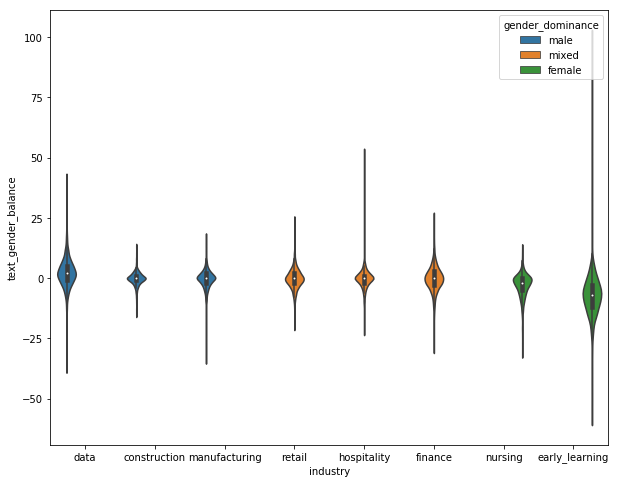

In [39]:
#plot gender balance by industry
plt.figure(figsize=(10,8))
sns.violinplot(x='industry', y='text_gender_balance', hue='gender_dominance', data=jd_df)

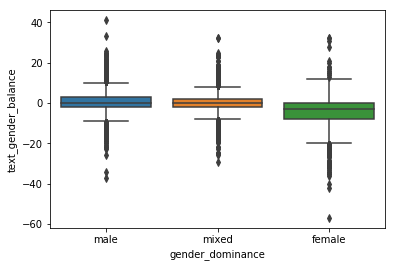

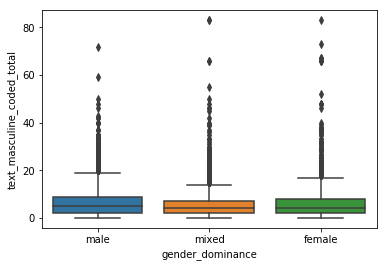

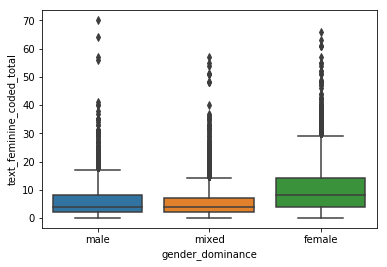

In [43]:
#plot gender balance by gender dominance
gender_balances = ['text_gender_balance', 'text_masculine_coded_total', 'text_feminine_coded_total']

for y in gender_balances :
    sns.boxplot(x='gender_dominance', y=y, data=jd_df)
    plt.show()

In [42]:
#appears to be a few extreme outliers
for y in gender_balances:
    print(jd_df[jd_df[y] > 100]['job_title'])

Series([], Name: job_title, dtype: object)
Series([], Name: job_title, dtype: object)
Series([], Name: job_title, dtype: object)


In [36]:
jd_df.iloc[[3448, 5625, 5834]]    

,prepped_text,index,company,company_rating,industry,job_description_all_text,job_title,location,salary_data_text,jd_no_stopwords,...,vader_sentiment_compound,textblob_sentiment,masculine_coded,feminine_coded,text_gender_balance,text_masculine_coded_total,text_feminine_coded_total,eoe_statement,vocab_size,lda_topic
3448,restaur collingwood seek - rounder join small ...,3449,Tonkin,NaN,hospitality,Restaurant in Collingwood seeking an all-round...,Kitchen Hand/Wait staff,Melbourne,NaN,restaurant collingwood seeking allrounder ...,...,0.9100,0.183631,{'least': 1},{'honest': 1},0,1,1,unknown,32,1
5625,posit titl traine posit number 20392 employ st...,5627,NSW Health Service,3.8,early_learning,Position Title Trainee Position Number 20392 ...,Trainee,Melbourne,"$81,639 - $127,539 a year",position title trainee position number 20...,...,0.9988,0.095782,"{'decision': 2, 'learn': 1, 'principles': 1, '...","{'responsible': 3, 'support': 2, 'responsibili...",-4,17,21,True,475,6
5834,refer : 1162053 locat profil aurora school dep...,5837,Victorian Government,3.5,early_learning,Reference: 1162053 Location Profile Aurora...,Speech Pathologist,Melbourne,NaN,reference 1162053 location profile aurora ...,...,0.9994,0.228102,"{'individual': 5, 'learning': 4, 'leadership':...","{'children': 18, 'support': 5, 'child': 4, 'ch...",-36,14,50,True,329,6


In [37]:
# commenting so not accidentally re-run on pre-cleaned
# print(jd_df.shape)
# jd_df.drop([3448, 5625, 5834],inplace=True)
# jd_df.reset_index(inplace=True)
# print(jd_df.shape)

(20025, 29)
(20022, 30)


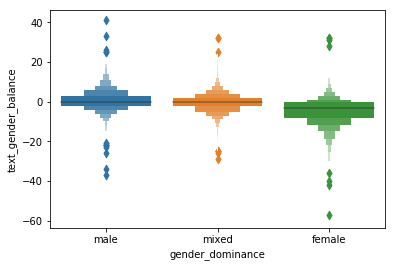

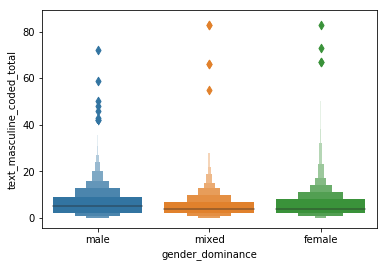

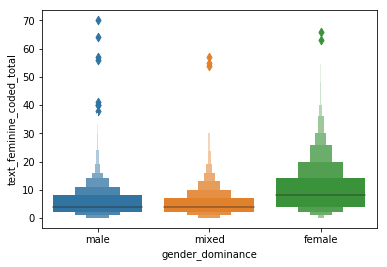

In [44]:
#plot gender balance by gender dominance
gender_balances = ['text_gender_balance', 'text_masculine_coded_total', 'text_feminine_coded_total']
for y in gender_balances :
    sns.boxenplot(x='gender_dominance', y=y, data=jd_df)
    plt.show()

In [45]:
#can clearly see that difference in feminine coded word use is significant
#is the difference in use of masculine coded words significant?

t_tests = {}
for col in gender_balances:
    t_test = stats.ttest_ind(jd_df[jd_df.gender_dominance == 'male'][col], 
                             jd_df[jd_df.gender_dominance == 'female'][col])
    t_tests[col] = t_test
    
t_test_df = pd.DataFrame(t_tests).transpose()
t_test_df.columns = ['test_statistic', 'p_val']
t_test_df.head()

,test_statistic,p_val
text_gender_balance,49.858038,0.000000
text_masculine_coded_total,3.797133,0.000147
text_feminine_coded_total,-39.309506,0.000000


#### Variance is wider for feminine coded words than masculine coded
Female dominated industries use far more female-coded words <br>
Data jobs are the most masculine coded. Given that any form of "analyze" is considered masculine-coded, this is not surprising

### Vocabulary Size as a Feature

In [89]:
vocab_size = [len(set(word_tokenize(jd))) for jd in jd_df.jd_no_stopwords]

In [90]:
jd_df['vocab_size'] = vocab_size

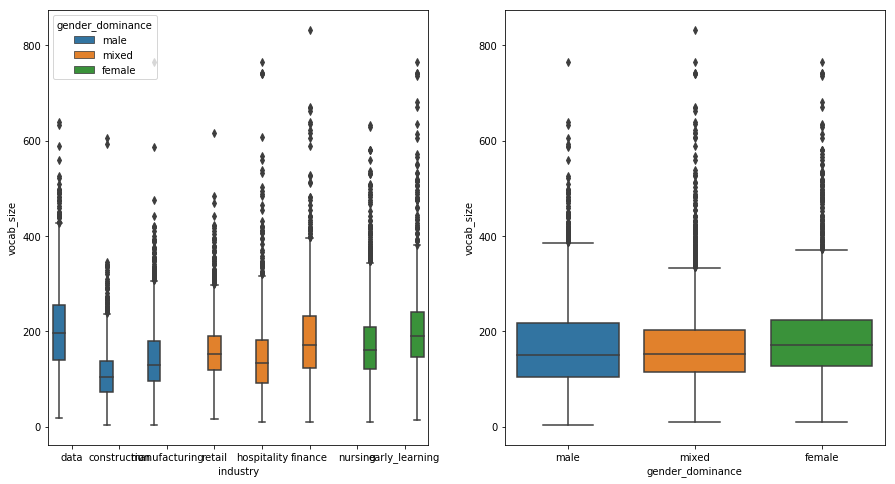

In [92]:
#visualize by industry, gender dominince
plt.subplots(1,2, figsize=(15,8))
sns.boxplot(x='industry', y='vocab_size', hue='gender_dominance', data=jd_df, ax=plt.subplot(1,2,1))
sns.boxplot(x='gender_dominance', y='vocab_size', data=jd_df, ax=plt.subplot(1,2,2))

In [46]:
#another way of looking at vocab size - this one still includes stopwords
cvect = CountVectorizer()

industry_vocab_size = {}
for industry in set(jd_df.industry.values):
    corpus = jd_df.job_description_all_text[jd_df.industry == industry]
    vocab_size = cvect.fit_transform(corpus).shape[1]
    industry_vocab_size[industry] = vocab_size

print(industry_vocab_size)



{'retail': 21587, 'finance': 22587, 'construction': 13886, 'early_learning': 15482, 'data': 27508, 'hospitality': 19526, 'manufacturing': 23081, 'nursing': 18853}


Unlikely to be useful information - although the female dominated industries use less words than most, construction uses the least

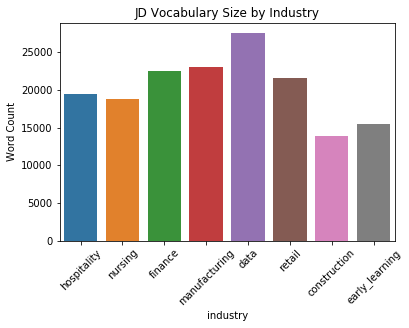

In [98]:
#add hue of gender??
lists = industry_vocab_size.items()
x, y = zip(*lists)
gender = []
for item in x:
    if item == 'data' or item == 'manufacturing' or item == 'construction':
        gender.append('male')
    elif item == 'nursing' or item == 'early_learning':
        gender.append('female')
    else:
        gender.append('mixed')
        
xy_df = pd.DataFrame(data=[x,y,gender]).transpose()
xy_df.columns=['industry', 'word_count', 'gender']

ax = sns.barplot(x='industry', y='word_count', data=xy_df)
ax.set_title('JD Vocabulary Size by Industry')
ax.set_ylabel('Word Count')
ax.tick_params(axis='x', rotation=45)


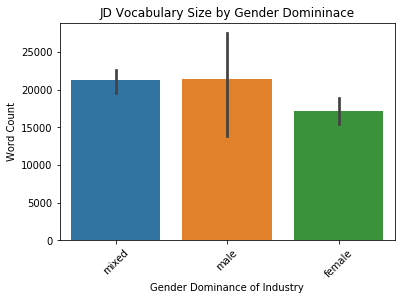

In [48]:
#add hue of gender??
lists = industry_vocab_size.items()
x, y = zip(*lists)
gender = []
for item in x:
    if item == 'data' or item == 'manufacturing' or item == 'construction':
        gender.append('male')
    elif item == 'nursing' or item == 'early_learning':
        gender.append('female')
    else:
        gender.append('mixed')
        
xy_df = pd.DataFrame(data=[x,y,gender]).transpose()
xy_df.columns=['industry', 'word_count', 'gender']

ax = sns.barplot(x='gender', y='word_count', data=xy_df)
ax.set_title('JD Vocabulary Size by Gender Domininace')
ax.set_ylabel('Word Count')
ax.set_xlabel('Gender Dominance of Industry')
ax.tick_params(axis='x', rotation=45)


### Looking at relationships with salary

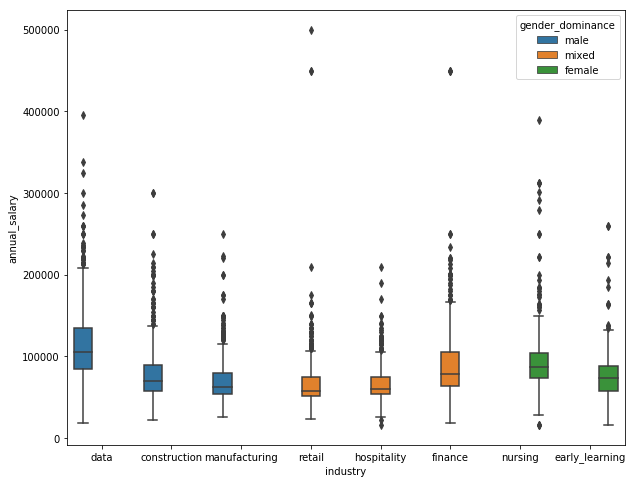

In [55]:
plt.figure(figsize=(10,8))
sns.boxplot(x='industry', y='annual_salary', hue='gender_dominance', data=jd_df)

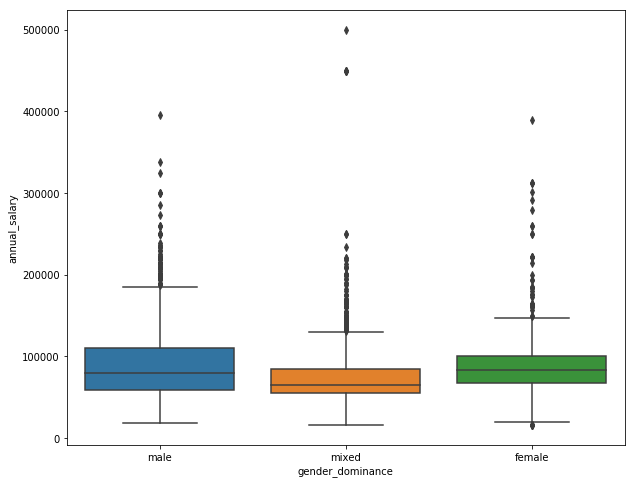

In [56]:
plt.figure(figsize=(10,8))
sns.boxplot(x='gender_dominance', y='annual_salary', data=jd_df)

## Model Development


### Preparing text for analysis

In [4]:
def text_stemmer(text):
    
    """
    Uses PorterStemmer on a text. Returns the stemmed text as a single string.
    """
    
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in word_tokenize(text)]
    
    return(' '.join(stemmed_words))
    

In [5]:
nlp = spacy.load('en')
    
def spacy_lemmatizer(text):
    '''
    Uses Spacy's built-in lemmatizer on a text; returns the lemmatized text as a single string
    '''
    lemmatized_words = [word.lemma_ for word in nlp(text)]
    return(' '.join(lemmatized_words))


def spacy_stopword_removal(text):
    '''
    Removes words on Spacy's stopwords list from text
    '''
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return(' '.join(tokens))

In [6]:
def prepare_text(text):
    '''
    removes stopwords, lemmatizes, and stems text
    '''
    no_stops = spacy_stopword_removal(text)
    stemmed_lemmatized_text = text_stemmer(spacy_lemmatizer(no_stops))
    return stemmed_lemmatized_text

In [94]:
# jd_df['prepped_text'] = [prepare_text(jd) for jd in jd_df.job_description_all_text]

# #saving df with prepped_text to csv, as it takes a long time to run
# jd_df.to_csv('./data/jd_with_prepped_text.csv', index=False)

# #also storing just prepped_text separately due to file size issues
# no_prepped_jd = jd_df.drop('prepped_text', axis=1)
# no_prepped_jd.to_csv('./data/no_prepped_jd.csv', index=False)
# jd_df.prepped_text.to_csv('./data/prepped_text.csv', index=False)

### Loading pre-prepped data

In [4]:
prepped_text = pd.read_csv('./data/prepped_text.csv', header=None, names=['prepped_text'])
no_prepped_jd = pd.read_csv('./data/no_prepped_jd.csv')

jd_df = pd.concat([prepped_text, no_prepped_jd], axis=1)
jd_df.shape

(20025, 28)

### Modelling prep: set up test-train split

In [5]:
train_mask = np.random.rand(len(jd_df)) < 0.8

train_rows = jd_df[train_mask]
test_rows = jd_df[~train_mask]

train_rows.shape, test_rows.shape

((16135, 28), (3890, 28))

In [9]:
#understanding baseline
jd_df.gender_dominance.value_counts(normalize=True)

mixed     0.410287
male      0.399600
female    0.190112
Name: gender_dominance, dtype: float64

### Initial model with features selected based on EDA
1. Vocab size (unlikely, but let's check)
1. Vader positive, neutral, compound; maybe negative
1. Total use of coded words

Company rating and salary provide differentiation between male & female dominated industries, but they are unrelated to how the job description itself can inform on gender balance, so will not be used for modelling.

In [7]:
#sentiments, coded words, vocab size
#model performs about 1% better with inclusion of vocab_size
X_EDA_feat = jd_df[['vader_sentiment_pos','vader_sentiment_neu','vader_sentiment_compound',
          'text_masculine_coded_total', 'text_feminine_coded_total', 'vocab_size']]

y = jd_df.gender_dominance

X_train_EDA = X_EDA_feat[train_mask]
y_train = y[train_mask]

X_test_EDA = X_EDA_feat[~train_mask]
y_test = y[~train_mask]

#test a couple of initial models
logreg = LogisticRegression(solver='liblinear')
rf = RandomForestClassifier()
for model in [logreg, rf]:
    model.fit(X_train_EDA, y_train)
    y_pred = model.predict(X_test_EDA)
    print(model)
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
0.555012853470437
[[215 218 301]
 [ 62 968 565]
 [ 66 519 976]]
              precision    recall  f1-score   support

      female       0.63      0.29      0.40       734
        male       0.57      0.61      0.59      1595
       mixed       0.53      0.63      0.57      1561

   micro avg       0.56      0.56      0.56      3890
   macro avg       0.57      0.51      0.52      3890
weighted avg       0.56      0.56      0.55      3890



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.5568123393316196
[[315 199 220]
 [119 989 487]
 [137 562 862]]
              precision    recall  f1-score   support

      female       0.55      0.43      0.48       734
        male       0.57      0.62      0.59      1595
       mixed       0.55      0.55      0.55      1561

   micro avg       0.56      0.56      0.56      3890
   macro avg       0.56      0.53      0.54      3890
weighted avg       0.56      0.56      0.55      3890



In [30]:
#making the confusion matrix nicer to look at
#adapted from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names=['female','male','mixed'], figsize = (7,5), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="GnBu")
    except ValueError:
        raise ValueError("Invalid convusion matrix supplied")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return fig

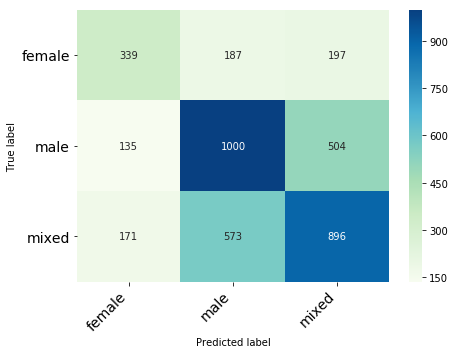

In [15]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
classes = ['female','male','mixed']

print_confusion_matrix(conf_matrix,classes);

### Test baseline models with job description text
Incorporate stemming / lemmatization

In [7]:
def test_pipeline(pipeline, X_train, X_test, y_train, y_test):
    '''Fits, predicts, and scores a pipeline
    Returns y_pred, score, and confusion matrix'''
    pipe = pipeline
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    print(score)
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    return y_pred, score, conf_matrix

In [6]:
X_jd = jd_df.prepped_text
y = jd_df.gender_dominance

X_train_jd = X_jd[train_mask]
y_train = y[train_mask]
X_test_jd = X_jd[~train_mask]
y_test = y[~train_mask]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8840579710144928


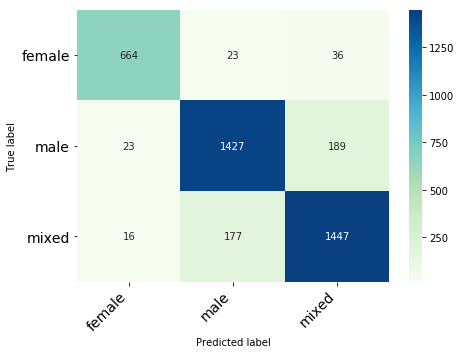

In [19]:
cvec = CountVectorizer(stop_words=None, ngram_range=(1,2), token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=.8)

logreg = LogisticRegression(solver='liblinear')

pipe = Pipeline(steps=[('cvec', cvec), ('logreg', logreg)])



results_1 = test_pipeline(pipe, X_train_jd, X_test_jd, y_train, y_test)
print_confusion_matrix(results_1[2], classes);

In [57]:
for max_df in [1.0, 0.9, 0.8, 0.7, 0.6]:
    tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=max_df)
    pipe = Pipeline(steps=[('tfidf',tfidf), ('logreg', logreg)])

    results_2 = test_pipeline(pipe, X_train_jd, X_test_jd, y_train, y_test)
# print_confusion_matrix(results_2[2], classes);

0.8898477157360406
0.8901015228426395
0.8898477157360406
0.8893401015228426
0.8880710659898478


In [58]:
for min_df in [1, 0.05, 0.1, 0.15]:
    tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9, min_df=min_df)
    pipe = Pipeline(steps=[('tfidf',tfidf), ('logreg', logreg)])

    results_2 = test_pipeline(pipe, X_train, X_test, y_train, y_test)

0.8901015228426395
0.8840101522842639
0.8723350253807106
0.8426395939086294


In [44]:
#is Lasso (l1) or Ridge (l2) helpful for improving score? 
for penalty in ['l1', 'l2']:
    
    logreg = LogisticRegression(penalty=penalty, solver='liblinear')
    tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9)
    pipe = Pipeline(steps=[('tfidf',tfidf), ('logreg', logreg)])

    results = test_pipeline(pipe, X_train_jd, X_test_jd, y_train, y_test)
    
print('Number of features:', len(pipe.named_steps['tfidf'].get_feature_names()))    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9030484757621189
0.8875562218890555
Number of features: 47424


### Feature Reduction
This model is currently using over 47,000 features. Looking at whether we use Truncated SVD, aka LSA (Latent Semantic Analysis), to reduce the number of features

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.879217100180273


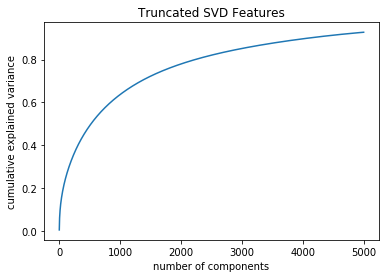

In [11]:
#choosing truncated SVD (LSA) for use with our sparse matrices

tsvd_n = TruncatedSVD(n_components=5000, random_state=0)
tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9)
logreg = LogisticRegression(penalty='l1', solver='liblinear')
pipe = Pipeline(steps=[('tfidf',tfidf), ('tsvd',tsvd_n), ('logreg',logreg)])

results_tsvd_tfidf = test_pipeline(pipe, X_train_jd, X_test_jd, y_train, y_test)

plt.plot(np.cumsum(pipe.named_steps['tsvd'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')  
plt.title ('Truncated SVD Features with tf-idf')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8498583569405099


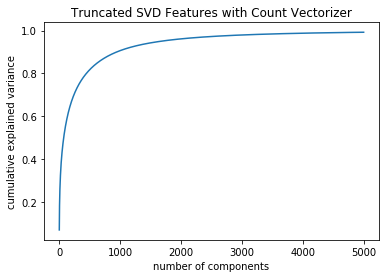

In [13]:
#choosing truncated SVD (LSA) for use with our sparse matrices

tsvd_n = TruncatedSVD(n_components=5000, random_state=0)
cvec = CountVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9)
logreg = LogisticRegression(penalty='l1', solver='liblinear')
pipe = Pipeline(steps=[('cvec',cvec), ('tsvd',tsvd_n), ('logreg',logreg)])

results_tsvd = test_pipeline(pipe, X_train_jd, X_test_jd, y_train, y_test)

plt.plot(np.cumsum(pipe.named_steps['tsvd'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')  
plt.title ('Truncated SVD Features with Count Vectorizer')
plt.show()

### Understanding differences between industry & class prediction
Although this model is performing quite well, I'm curious whether it's learning to predict classes via the industries, or learning true similarities within the classes <br>
Potential directions for this:
* Test models on data representing different male & female dominated industries
* Attempt to identify features that are highly predictive between the industries making up a class and eliminate those features (for example words like "nurse" are currently likely to be good predictors of our female class, but that is predicting via knowing the industry)
* oversampling / shuffling within the class
* shuffling within the class, but across industry



In [20]:
#creating function to generate features in new data
#features of interest are: vader sentiments, gender coded words, prepped text
def create_features(clean_df):
    
    '''Puts a dataframe of cleaned data through feature creation process
    Features include vader sentiments, gender coded words, vocab size, and prepped jd text.
    Also creates the gender_dominance target
    '''
    
    feature_df = clean_df.copy()
     
    #vader sentiment
    feature_df.jd_no_stopwords = feature_df.jd_no_stopwords.map(jd_no_stops_stripper) #format bow back to string   
    vader = SentimentIntensityAnalyzer()
    feature_df['vader_sentiment'] = [vader.polarity_scores(jd) for jd in feature_df.jd_no_stopwords]
    feature_df['vader_sentiment_neg'] = feature_df.vader_sentiment.map(lambda x: x['neg'])
    feature_df['vader_sentiment_pos'] = feature_df.vader_sentiment.map(lambda x: x['pos'])
    feature_df['vader_sentiment_neu'] = feature_df.vader_sentiment.map(lambda x: x['neu'])
    feature_df['vader_sentiment_compound'] = feature_df.vader_sentiment.map(lambda x: x['compound'])    
    
    #gender coded words
    feature_df['masculine_coded'] = [match_word_count(jd, masculine_coded_words.masculine) 
                                     for jd in feature_df.jd_no_stopwords]
    feature_df['feminine_coded'] = [match_word_count(jd, feminine_coded_words.feminine)
                                    for jd in feature_df.jd_no_stopwords]
    
    jd_gender_balance = [get_text_gender_balance(feature_df.masculine_coded[i], feature_df.feminine_coded[i]) 
                         for i in feature_df.index]
    
    feature_df['text_gender_balance'] = [balance[0] for balance in jd_gender_balance]
    feature_df['text_masculine_coded_total'] = [balance[1] for balance in jd_gender_balance]
    feature_df['text_feminine_coded_total'] = [balance[2] for balance in jd_gender_balance]
    
    #vocab size
    feature_df['vocab_size'] = [len(set(word_tokenize(jd))) for jd in feature_df.jd_no_stopwords]
    
    #prepped text
    feature_df['prepped_text'] = [prepare_text(jd) for jd in feature_df.job_description_all_text]
    
    #target (gender dominance)
    industry_gender_dict = {'data':'male', 'manufacturing':'male', 'construction':'male', 
                      'plumbing':'male', 'mining':'male', 'nursing':'female',
                      'early_learning':'female', 'socialworker':'female'} 
    gender_dominance_list = []
    for industry in feature_df.industry:
        gender_dominance_list.append(industry_gender_dict[industry])
    feature_df['gender_dominance'] = gender_dominance_list

    
        
    return feature_df

    

In [27]:
# #using a separately collected dataset from different industries (mining, plumbing, social work) to test this theory
# test_filepath = './data/test_mining_plumbing_socialwork_clean.csv'
# fresh_test_df = pd.read_csv(test_filepath)
# print(fresh_test_df.shape, '\n', fresh_test_df.columns)


(4260, 12) 
 Index(['company', 'company_rating', 'job_description_all_text', 'job_title',
       'location', 'salary_data_text', 'industry', 'jd_no_stopwords',
       'salary_values', 'salary_period', 'salary_multiplier', 'annual_salary'],
      dtype='object')


In [28]:
# #adding features to dataframe
# test_new_df = create_features(fresh_test_df)
# test_new_df.gender_dominance.value_counts(normalize=True)

male      2782
female    1478
Name: gender_dominance, dtype: int64

In [21]:
# saving file with full features for future use
# test_new_df.to_csv('./data/mining_plumbing_socialwork_prepped.csv')

#load saved file in the future
test_new_df = pd.read_csv('./data/mining_plumbing_socialwork_prepped.csv')

y_test_new = test_new_df.gender_dominance

X_cols = ['vader_sentiment_pos','vader_sentiment_neu','vader_sentiment_compound',
          'text_masculine_coded_total', 'text_feminine_coded_total', 'vocab_size']

X_new_EDA = test_new_df[X_cols]

X_new_jd = test_new_df.prepped_text


#### Testing on EDA identified features

Baseline: 
 male      0.653052
female    0.346948
Name: gender_dominance, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.4955399061032864


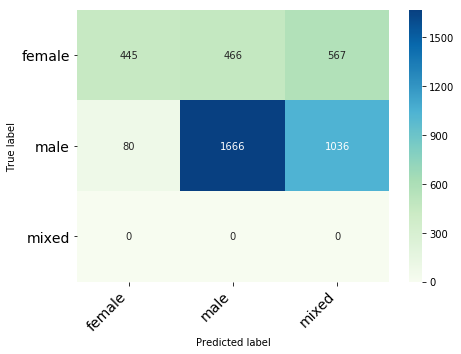

In [52]:
print('Baseline:', '\n', y_test_new.value_counts(normalize=True))

pipe_EDA = Pipeline(steps=[('logreg',logreg)])
test_new_EDA_results = test_pipeline(pipe_EDA, X_train, X_new_EDA, y_train, y_test_new)
print_confusion_matrix(test_new_EDA_results[2]);


It appears this model has almost no ability to separate out the female dominated roles, but is able to tell that the male dominated roles are not female

#### Testing on job description text based models 

In [111]:
cvec = CountVectorizer(stop_words=None, ngram_range=(1,2), token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=.9)
tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9)
logreg = LogisticRegression(solver='liblinear')

pipe_cvec = Pipeline(steps=[('cvec', cvec), ('logreg', logreg)])
pipe_tfidf = Pipeline(steps=[('tfidf', tfidf), ('logreg', logreg)])

cvec_test_new_results = test_pipeline(pipe_cvec, X_train_jd, X_new_jd, y_train, y_test_new)
tfidf_test_new_results = test_pipeline(pipe_tfidf, X_train_jd, X_new_jd, y_train, y_test_new)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7488262910798122
0.7922535211267606


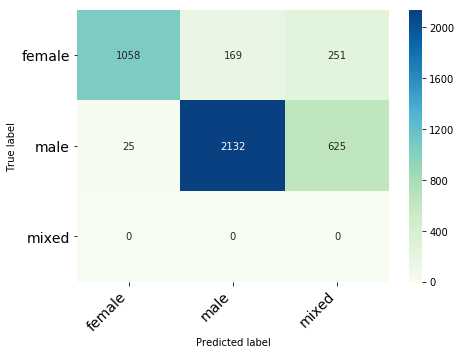

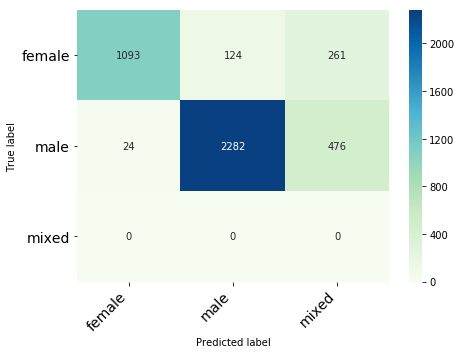

In [112]:
print('CVEC Model')
print_confusion_matrix(cvec_test_new_results[2]);
print('\n')
print('TFIDF Model')
print_confusion_matrix(tfidf_test_new_results[2]);

### Final model selection
Testing combining models to see if results can be improved

In [8]:
#most successful models so far: cvec & tfidf with 0.9 max_df
#sentiment/vocab model is less strong, but may still add information when linked with others

cvec = CountVectorizer(stop_words=None, ngram_range=(1,2), token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=.9)
tsvd_cv = TruncatedSVD(n_components=1000, random_state=0)

tfidf = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]{3,}\b', max_df=0.9)
tsvd_tfidf = TruncatedSVD(n_components=4000, random_state=0)

logreg = LogisticRegression(solver='liblinear', penalty='l1')

pipe_cvec = Pipeline(steps=[('cvec', cvec), ('tsvd', tsvd_cv), ('logreg', logreg)])
pipe_tfidf = Pipeline(steps=[('tfidf', tfidf), ('tsvd', tsvd_cv), ('logreg', logreg)])
pipe_EDA = Pipeline(steps=[('logreg',logreg)])


In [25]:
pipe_cvec.fit(X_train_jd, y_train)

filename_1 = 'model_cvec'
with open(filename_1, 'wb') as f1:
    pickle.dump(pipe_cvec, f1, protocol=4)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


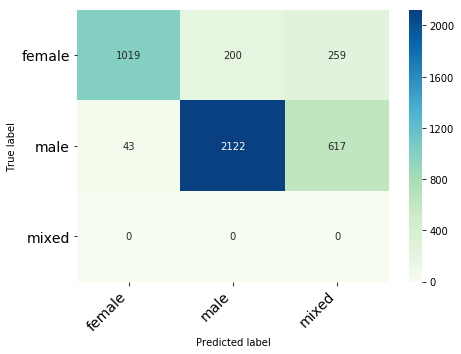

In [35]:
with open('model_cvec', 'rb') as f:
    saved_cvec_pipeline = dill.load(f)
    
yhat_new = saved_cvec_pipeline.predict(X_new_jd)
X_new_conf_matrix = metrics.confusion_matrix(y_test_new, yhat_new)
print_confusion_matrix(X_new_conf_matrix);

In [36]:
pipe_tfidf = Pipeline(steps=[('tfidf', tfidf), ('tsvd', tsvd_cv), ('logreg', logreg)])
pipe_tfidf.fit(X_train_jd, y_train)

filename_1 = 'model_tfidf'
with open(filename_1, 'wb') as f1:
    pickle.dump(pipe_tfidf, f1, protocol=4)
    


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


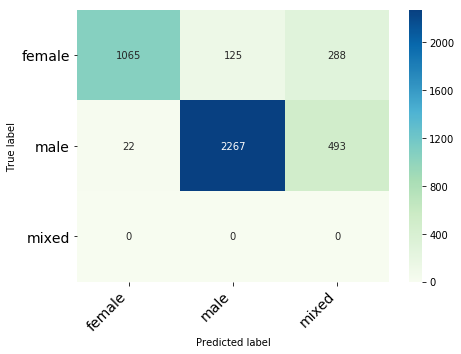

In [38]:
with open('model_tfidf', 'rb') as f:
    saved_tfidf_pipeline = dill.load(f)
    
yhat_new_tfidf = saved_tfidf_pipeline.predict(X_new_jd)
X_new_conf_matrix_tfidf = metrics.confusion_matrix(y_test_new, yhat_new_tfidf)  
print_confusion_matrix(X_new_conf_matrix_tfidf);

In [41]:
pipe_EDA.fit(X_train_EDA, y_train)

filename_1 = 'model_sentiment'
with open(filename_1, 'wb') as f1:
    pickle.dump(pipe_EDA, f1, protocol=4)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


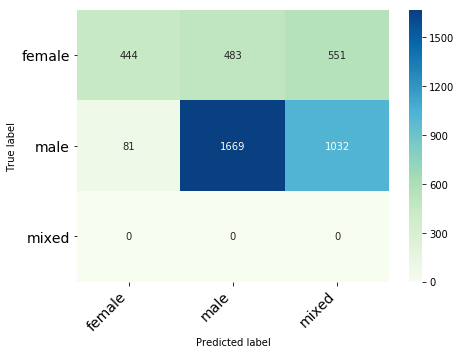

In [42]:
with open('model_sentiment', 'rb') as f:
    saved_sentiment_pipeline = dill.load(f)
    
yhat_new_sentiment = saved_sentiment_pipeline.predict(X_new_EDA)
X_new_conf_matrix_sentiment = metrics.confusion_matrix(y_test_new, yhat_new_sentiment)  
print_confusion_matrix(X_new_conf_matrix_sentiment);

In [43]:
prob_cvec = saved_cvec_pipeline.predict_proba(X_new_jd)
prob_tfidf = saved_tfidf_pipeline.predict_proba(X_new_jd)
prob_sentiment = saved_sentiment_pipeline.predict_proba(X_new_EDA)

0.7593896713615024


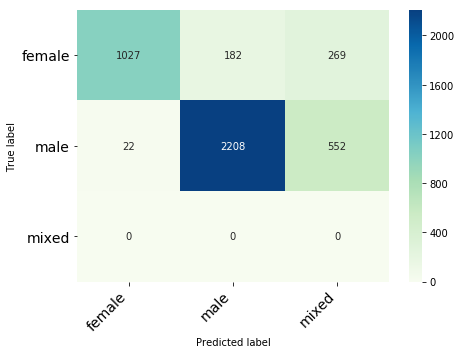

In [63]:
combined_probabilities = []
for i in range(len(prob_cvec)):
    comb_prob_i = 0.4*prob_cvec[i] + 0.4*prob_tfidf[i] + 0.2*prob_sentiment[i]
    combined_probabilities.append(comb_prob_i)

results = [np.array(elements).argmax() for elements in combined_probabilities]

y_hats_combined = ['female' if n == 0 
                  else 'male' if n == 1
                  else 'mixed'
                  for n in results]

conf_matrix_combined = metrics.confusion_matrix(y_test_new, y_hats_combined)  
print(metrics.accuracy_score(y_test_new, y_hats_combined))
print_confusion_matrix(conf_matrix_combined);

0.7605633802816901


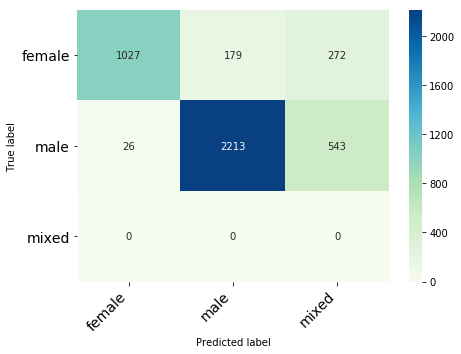

In [64]:
combined_probabilities2 = []
for i in range(len(prob_cvec)):
    comb_prob_i = 0.5*prob_cvec[i] + 0.5*prob_tfidf[i]
    combined_probabilities2.append(comb_prob_i)

results2 = [np.array(elements).argmax() for elements in combined_probabilities2]

y_hats_combined2 = ['female' if n == 0 
                  else 'male' if n == 1
                  else 'mixed'
                  for n in results2]

conf_matrix_combined2 = metrics.confusion_matrix(y_test_new, y_hats_combined2)  
print(metrics.accuracy_score(y_test_new, y_hats_combined2))
print_confusion_matrix(conf_matrix_combined2);

0.7821596244131456


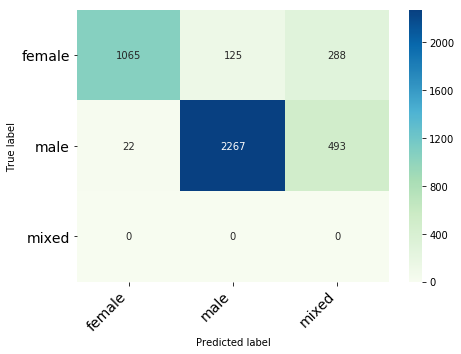

In [68]:
#reminder of what the best individual model was scoring:
yhat_new_tfidf = saved_tfidf_pipeline.predict(X_new_jd)
X_new_conf_matrix_tfidf = metrics.confusion_matrix(y_test_new, yhat_new_tfidf)  
print(metrics.accuracy_score(y_test_new, yhat_new_tfidf))
print_confusion_matrix(X_new_conf_matrix_tfidf);

In [79]:
probs_tfidf = saved_tfidf_pipeline.predict_proba(X_new_jd)

In [89]:
probs_tfidf[3111]

array([0.77127254, 0.08774051, 0.14098695])

In [90]:
test_new_df.job_description_all_text.iloc[3111]

"Healthcare Australia is Australia's largest specialist recruitment and staffing provider in the Health and Community Care industry. We look for people who share our core values of Integrity, Excellence, Collaboration, Sustainability and Innovation.        The role        We are seeking committed Disability Support Workers for ongoing shifts in the Melton, Caroline Springs and Brimbank area. Your primary role will be providing one on one support to our NDIS participants within their home or out in the community. This can include assisting with daily living activities, providing domestic assistance, as well as personal care, transport, and other aspects of daily living as specified by their NDIS plan.        If you are a person with a kind, patient and empathetic nature, and willing to provide with your upmost care, carrying a positive can-do attitude; then this role could be a match for you.        Eligibility Criteria:        Minimum of 6 months paid experience in supporting people wi

### TFIDF is the most accurate model
Combinations with other models have not been identified which can balance the errors in the tfidf model, so that model alone is currently the best option to move forward with

## Detecting Equal Opportunity Employer statements

In [99]:
#this is a simplistic version, and an example where neural networks could be helpful
#if these words appear near each other in a text, it is much more likely they are being used in an EOE statement 

def eoe_detector(job_description):
    '''Predicts whether or not a job description includes an Equal Opportunity Employer statement'''
    
    eoe_re_patterns = ['equal opportunity', 'gender', 'LGBT*', 'sex', 'inclusi*', 
                      'cultures', 'divers*', 'relig*', 'disab*', 'sexual orientation',
                      'aboriginal', 'torres strait', 'marital', 'pregnancy'] 
    
    #played around with the function a little to understand which terms were too general & useful cutoff for setting True
    #removed the following words which seemed likely to have other common uses: difference, respect, celebrate, race, age, origin
    #very vew of these words are commonly used in other contexts in jds 
    #potential examples: cultures in biology, pregnancy in nursing, inclusive or diverse could be used to describe other job aspects
    
    jd = job_description.lower()
    if re.search('equal opportunity employer', jd):
        eoe = True
    
    else:
        eoe_count = 0
        for pattern in eoe_re_patterns:
            if re.search(pattern, job_description):
                eoe_count += 1
                
        #setting the cutoff at 2 - unlikely that many which do not meet this standard have an EOE statement
        #prefer to get a sense of the lower end - how many are doing nothing of this sort
        if eoe_count >= 2:
            eoe = True
        elif eoe_count > 0:
            eoe = 'unknown'
        else:
            eoe = False
            
    return eoe        

In [100]:
#creating small set of EOE statements to test detection using 
#https://blog.ongig.com/diversity-and-inclusion/eeo-statement-samples
#these examples are not from Australia, so some differences are likely
eoe_test_df = pd.read_csv('./data/eoo_examples.csv')
pd.set_option('display.max_colwidth', -1)
eoe_test_df

,eoe_statement
0,"At Google, we don?t just accept difference ? we celebrate it, we support it, and we thrive on it for the benefit of our employees, our products, and our community. Google is proud to be an equal opportunity workplace and is an affirmative action employer."
1,"At Under Armour, we are committed to providing an environment of mutual respect where equal employment opportunities are available to all applicants and teammates without regard to race, color, religion, sex, pregnancy (including childbirth, lactation and related medical conditions), national origin, age, physical and mental disability, marital status, sexual orientation, gender identity, gender expression, genetic information (including characteristics and testing), military and veteran status, and any other characteristic protected by applicable law. Under Armour believes that diversity and inclusion among our teammates is critical to our success as a global company, and we seek to recruit, develop and retain the most talented people from a diverse candidate pool."
2,Comcast is an EOE/Veterans/Disabled/LGBT employer
3,"Dell is an Equal Opportunity Employer and Prohibits Discrimination and Harassment of Any Kind: Dell is committed to the principle of equal employment opportunity for all employees and to providing employees with a work environment free of discrimination and harassment. All employment decisions at Dell are based on business needs, job requirements and individual qualifications, without regard to race, color, religion or belief, national, social or ethnic origin, sex (including pregnancy), age, physical, mental or sensory disability, HIV Status, sexual orientation, gender identity and/or expression, marital, civil union or domestic partnership status, past or present military service, family medical history or genetic information, family or parental status, or any other status protected by the laws or regulations in the locations where we operate. Dell will not tolerate discrimination or harassment based on any of these characteristics."
4,Equal Opportunity Employer
5,"Facebook is proud to be an Equal Employment Opportunity and Affirmative Action employer. We do not discriminate based upon race, religion, color, national origin, gender (including pregnancy, childbirth, or related medical conditions), sexual orientation, gender identity, gender expression, age, status as a protected veteran, status as an individual with a disability, or other applicable legally protected characteristics."
6,"Our goal is to be a diverse workforce that is representative, at all job levels, of the citizens we serve.ÿ IMP Group Ltd. has an Employment Equity Policy and we welcome applications from Aboriginal People, African Nova Scotian?s and Other Racially Visible People, Persons with Disabilities and Women in occupations or positions where they are under represented.ÿ If you are a member of one of the equity groups, you are encouraged to self-identify, on either your application form, covering letter or resume."
7,"Tesla is an equal opportunity employer. All aspects of employment including the decision to hire, promote, discipline, or discharge, will be based on merit, competence, performance, and business needs. We do not discriminate on the basis of race, color, religion, marital status, age, national origin, ancestry, physical or mental disability, medical??? condition, pregnancy, genetic information, gender, sexual orientation, gender identity or ?expression, veteran status, or any other status protected under federal, state, or local law."
8,"Textio embraces diversity and equal opportunity in a serious way. We are committed to building a team that represents a variety of backgrounds, perspectives, and skills. The more inclusive we are, the better our work will be."
9,"The United States Government does not discriminate in employment on the basis of race, color, religion, sex (including pregnancy and gender identity), national origin, political affiliation,

In [101]:
eoe_test_df['eoe_pred'] = eoe_test_df.eoe_statement.apply(eoe_detector)
print(eoe_test_df.eoe_pred.value_counts())


True       12
unknown    3 
Name: eoe_pred, dtype: int64


In [102]:
jd_df['eoe_statement'] = jd_df.job_description_all_text.apply(eoe_detector)
jd_df.eoe_statement.value_counts()

False      11879
unknown    4164 
True       3982 
Name: eoe_statement, dtype: int64

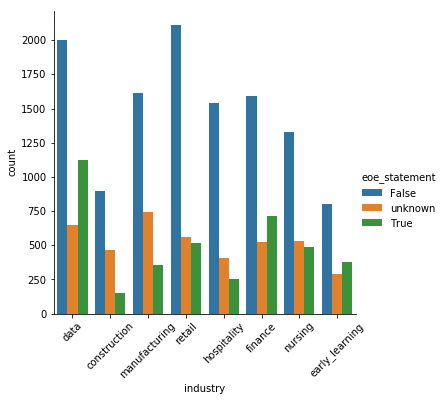

In [160]:
sns.catplot(x='industry', data=jd_df, hue='eoe_statement', kind='count')
plt.tick_params(axis='x', rotation=45)


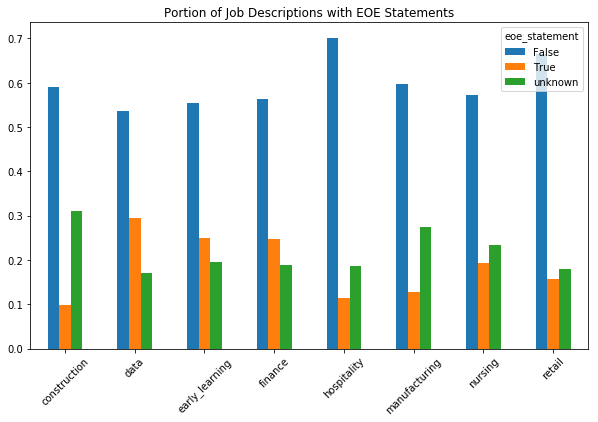

In [58]:
eoe_percent_df2 = jd_df.groupby('industry')['eoe_statement'].value_counts(normalize=True).unstack()
eoe_percent_df2.reset_index(inplace=True)

eoe_percent_df2.plot(kind='bar', figsize=(10,6))
ind = np.arange(8)
plt.xticks(ind, (eoe_percent_df2.industry), rotation=45)
plt.title('Portion of Job Descriptions with EOE Statements')
plt.show()

Text(0.5, 1.0, 'Portion of Job Descriptions with EOE Statements')

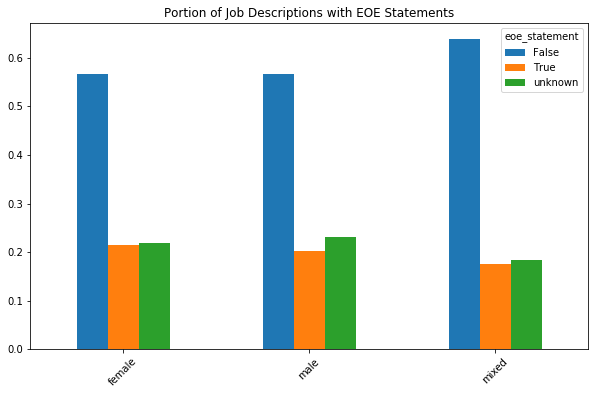

In [59]:
#would rather see this as percentages
# count of eoe t/f/u / count of industry
eoe_percent_df = jd_df.groupby('gender_dominance')['eoe_statement'].value_counts(normalize=True).unstack()
eoe_percent_df.reset_index(inplace=True)

eoe_percent_df.plot(kind='bar', figsize=(10,6))
ind = np.arange(3)
plt.xticks(ind, (eoe_percent_df.gender_dominance), rotation=45)
plt.title('Portion of Job Descriptions with EOE Statements')


In [129]:
eoe_percent_df.head()

eoe_statement,gender_dominance,False,True,unknown
0,female,0.558182,0.226950,0.214867
1,male,0.563984,0.204074,0.231942
2,mixed,0.637902,0.180745,0.181353


In [132]:
#looking at a few job adds to see if they are categorized correctly
jd_df[jd_df.eoe_statement == False]['job_description_all_text'].iloc[[42,159,4458,5218,7812,11000]]

103      24 month contract with extension options State of the Art Facility Must be an Aus Citizen but will sponsor for clearance  The Role... The Defence Science & Technology Group (DST) has a requirement for a skilled candidate to take over the operational maintenance and stock control of their onsite Chemical Storage and Drum Store facility in Melbourne. You will be required to maintain the storage facility in line with all Commonwealth Work Health and Safety legislation and ensure compliance for handling, storage, labelling, and safety data sheets maintenance and disposal of all chemicals held within the store in line with Defence and legislative requirements. You will also provide subject matter expertise in the control of hazardous chemicals for research activities.  You Will Need... Demonstrated knowledge of research chemicals, their correct storage and handling and any associated legislation Previous experience in managing the storage of hazardous chemicals Qualifications in a 

In [144]:
#the last example below does not include an eoe statement, but is marked "true" due to recognition of Aboriginal / Torres Strait peoples
jd_df[jd_df.eoe_statement == True]['job_description_all_text'].iloc[[42,159,458,564,2354,3800]]

82       As part of the continued growth and innovation of our Site Investigation and Risk Assessment (SIRA) team, ERM has opportunities for experienced scientists (thereafter referred to as consultants) to join our global consulting firm in Melbourne/ Victoria on a permanent basis. Our large-scale project wins across ANZ have opened up key opportunities for consultants keen to move into a global consulting firm with access to high profile and complex environmental projects. Notably, we have secured a multi-year closure & rehabilitation project in vicinity of La Trobe Valley (2.5 hours away from Melbourne) that demands cross-disciplinary support to address the complex environmental issues associated with it, which includes, but not limited to technical areas of: Field investigations Human health and ecological risk assessments Contaminant Hydrogeology Remediation Environmental compliance & approvals We are seeking consultants of various levels to join us, from fresh graduates through t

## Opportunities for continued model development
1. BERT / Neural networks - neural networks work well for NLP tasks due to the ability to incorporate context, which is an essential element of language. One direction for this would be using  pre-trained base layers from general language, then training a final layer on job descriptions.
2. Incorporate training data from a wider range of industries
3. Allow multi-industry tagging (e.g. an analysts in retail, finance, or mining may have different characteristics)
4. Incorporate modelling of position level (e.g. manager / executive)